### Trending YouTube Video Statistics
Daily statistics for trending YouTube videos

### Description
YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.

This dataset is a daily record of the top trending YouTube videos in USA for several months.

First we are going to import everything we need to do the analysis

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import itertools
import json
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from wordcloud import WordCloud


plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=14, titlepad=10)

Let's have a look at our dataset! First I will take care of the time format columns; from them I will extract three additional columns that will be helpful for the exploratory analysis (day, hour and month of publication)

In [38]:
url = r"C:\Users\gonza\Downloads\Trending YouTube Video Statistics\USvideos.csv"
data = pd.read_csv(url,parse_dates=["publish_time"])
data.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


### Analyzing the time !

In [39]:
# first convert trending date to datetime format
data["trending_date"] = data["trending_date"].apply(lambda x : datetime.strptime(x,"%y.%d.%m"))
# create three columns , using dt function to extract dayofweek, hour and month
data["publish_day_week"] = data["publish_time"].dt.dayofweek
data["publish_hour"] = data["publish_time"].dt.hour
data["publish_month"] = data["publish_time"].dt.month

I will see the evolution of the number of views of the videos over time; for this I use the Rolling function and I group them by week to better appreciate the trend

Text(0, 0.5, 'Total Views')

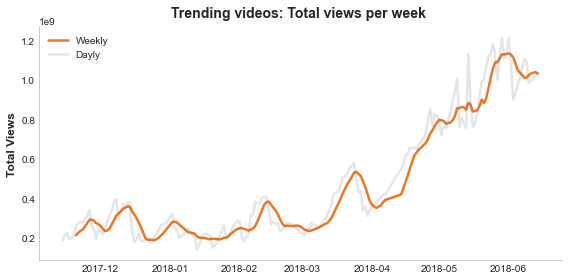

In [40]:
# groupby trending date by views
time = data.groupby("trending_date")["views"].sum()


# let,s plot using rolling (7 -> week)
plt.figure(figsize=(8,4))
sns.lineplot(data=time.rolling(7).mean(), linewidth=2.5,color="#EB7827",label="Weekly")
sns.lineplot(data=time, linewidth=2.5,color="grey",alpha=0.2,label="Dayly")
# using plt.grid and sns.despine you get a cleaner look in the graphics
plt.grid(None)
sns.despine()
plt.title("Trending videos: Total views per week ")
plt.ylabel("Total Views")

From April 2018 the sights will go off like a rocket! BTS has surely released a new song :) 

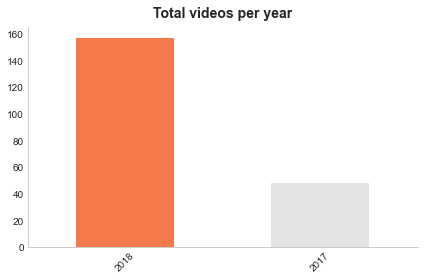

In [41]:
# Let's check how many videos there are per year in the dataset; using the same dataframe as before (Time) and reset_index, to facilitate their visualization.
year = time.reset_index()

#now with reset_index I have two columns, the number of views and trending_date; as before I use the dt.year function to extract the year and value_counts to count them.
year_count = year.trending_date.dt.year.value_counts()
year_count.plot(kind="bar",color=["#F6794B","#E3E3E3"])
plt.xticks(rotation=45)
plt.title("Total videos per year")
sns.despine()
plt.grid(None)

Most videos belong to 2018!

Let's continue with time charts; let's see what day, month and time the videos are usually published!

First I group the views by day of the week; then I create a dictionary with the days of the week to convert the numbers into strings and make the display more enjoyable

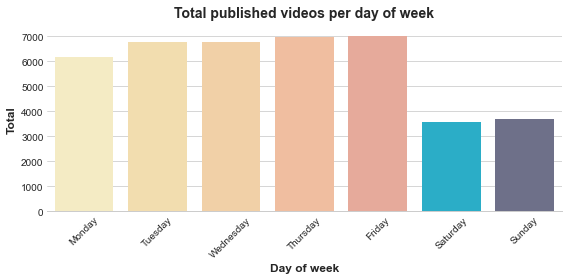

In [42]:
# creating a dict
numeros = [*range(7)]
day = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dict_day = {}
for key,item in zip(day,numeros):
   dict_day[item] = key
# groupby by day of week
day_week = data.groupby("publish_day_week").size().reset_index()
# apply dict to publish day week column using map
day_week["publish_day_week"] = day_week["publish_day_week"].map(dict_day)

# let,s plot ¡¡
plt.figure(figsize=(8,4))
colors = ["#FAEFBE","#FAE0A7","#FAD19E","#FABC96","#EFA492","#18BADA","#6B6D8C"]
sns.barplot(x="publish_day_week",y=0,data=day_week,palette=colors,saturation=0.8)
plt.title("Total published videos per day of week")
plt.xlabel("Day of week")
plt.ylabel("Total")
plt.xticks(rotation=45)
sns.despine(left=True)

We see that on weekends the Youtubers tend to rest and they tend to upload more videos on Thursday and Friday. Now I will do the same but with the months of the year

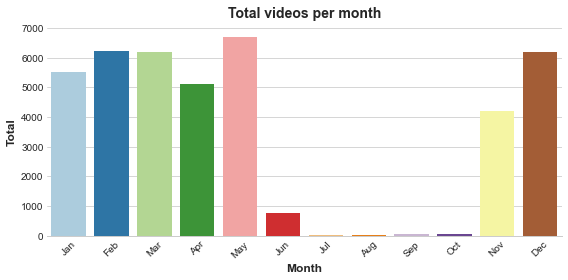

In [43]:
numeros_año = [*range(1,13)]
month = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']

dict_month = {}
for key,item in zip(month,numeros_año):
   dict_month[item] = key

month_df = data.groupby("publish_month").size().reset_index()

month_df["publish_month"] = month_df["publish_month"].map(dict_month)

plt.figure(figsize=(8,4))

sns.barplot(x="publish_month",y=0,data=month_df,palette="Paired",saturation=0.8)
plt.xlabel("Month")
plt.ylabel("Total")
plt.title("Total videos per month")
plt.xticks(rotation=45)
sns.despine(left=True)

Ahhhh the summer months people prefer to go to the beach or the mountains instead of uploading videos, and it makes a lot of sense, you have to enjoy the good weather!

And finally, let's see what time the Youtubers usually upload their videos!

Text(0.5, 1.0, 'Number of videos uploaded per hour')

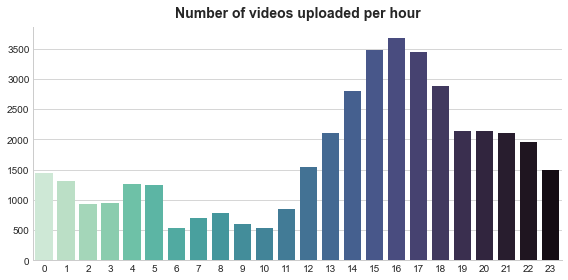

In [44]:
hour = data.groupby("publish_hour").size()

plt.figure(figsize=(8,4))
sns.barplot(x=hour.index.values,y=hour.values,palette="mako_r")
sns.despine()
plt.title("Number of videos uploaded per hour")

There are many Youtubers who do not sleep at night! The truth is that the night is when it is quieter, there are fewer distractions and noise.

### Channels, Youtubers...
There is a column in our dataframe called category_id but they are numbers; luckily there is a Json file, where we can find the video categories. 
Let's create, as we did before with the dates, a dictionary of video categories!

In [45]:
# First we load the json file
url = r"C:\Users\gonza\Downloads\Trending YouTube Video Statistics\US_category_id.json"
with open(url) as f:
    data_json = json.load(f)["items"]

In [46]:
# # how is a json file? well, let,say they are dictionaries within dictionaries..
data_json[0]

{'kind': 'youtube#videoCategory',
 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"',
 'id': '1',
 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
  'title': 'Film & Animation',
  'assignable': True}}

In [47]:
# create a dict with titles (we go first to snippet and them title)
title_dict = {}
for cat in data_json:

    title_dict[int(cat["id"])] = cat["snippet"]["title"]
    

In [48]:
# now we use map to apply it to the dataframe so we can work better!
data["category_id"] = data["category_id"].map(title_dict)
# let's see what percentage of videos per category are in our dataframe.


In [55]:
# let's see what percentage of videos per category are in our dataframe. First, with value_counts and normalize we get the relative frequency
categorys = data["category_id"].value_counts(normalize=True).reset_index()
# rename columns names
categorys.rename(columns={"index":"Category","category_id":"Percentage"},inplace=True)
# get percentage
categorys["Percentage"] = round(categorys["Percentage"] *100,2)
# we use style background ¡
categorys.style.background_gradient(cmap='mako_r')

,Category,Percentage
0,Entertainment,24.330000
1,Music,15.810000
2,Howto & Style,10.120000
3,Comedy,8.440000
4,People & Blogs,7.840000
5,News & Politics,6.070000
6,Science & Technology,5.860000
7,Film & Animation,5.730000
8,Sports,5.310000
9,Education,4.040000


Forty percent of the videos belong to the categories Music and Enterteiment ¡¡

In our dataframe there are columns that we can play with, for example likes, dislikes; we can create new columns like the percentage of likes by views, or the percentage of dislikes by views...

In [50]:
# Well, neither one nor the other, I will do better the sum of both, that is, the percentage of like/dislikes by views....
total = data["likes"] + data["dislikes"]

On second thought, I will also take into account the comments; I will create a column that will measure the percentage of user interactions based on the number of views

In [51]:
# let's add up the comments.
total_def = data["comment_count"] + total
# we created a new column...percentage iterations per view ¡¡¡
data["percentage_iterations_per_view"] = round((total_def / data["views"]) * 100,2)

I created a small function to group, average and sort the following columns ("views", "likes", "dislikes", "comment_count", "percentage_iterations_per_view")

In [60]:
def data_views(groupby="channel_title",by="percentage_iterations_per_view",ascending=False):
    """
    return dataframe groupby channels, showing mean from columns:
    "views","likes","dislikes","comment_count","percentage_iterations_per_view"
    ,sort by and ascending included
    """
    return  (data
            .groupby(groupby)["views","likes","dislikes","comment_count","percentage_iterations_per_view"]
            .mean()
            .sort_values(by=by,ascending=ascending)
            )

In [61]:
# Let's take a look; these are the channels ordered by "percentage_iterations_per_view"
data_views().head(10)

,views,likes,dislikes,comment_count,percentage_iterations_per_view
channel_title,,,,,
Daily Caller,1.175780e+06,9.346667e+03,223806.333333,28903.333333,22.290000
Desimpedidos,5.031049e+06,1.017472e+06,3596.333333,78330.000000,22.100000
KickThePj,8.320000e+04,1.526200e+04,26.000000,881.000000,19.430000
Amber Liu,1.545602e+05,2.663280e+04,37.400000,2287.200000,18.942000
HarryStylesVEVO,2.323018e+06,2.699427e+05,3074.833333,15734.833333,18.231667
Scotty Sire,7.399617e+05,1.195365e+05,414.000000,10590.166667,18.075000
Max Joseph,8.953520e+05,1.417310e+05,2413.000000,11279.000000,17.360000
dodieVEVO,3.903665e+05,5.702217e+04,508.333333,4638.250000,17.030000
LouisTomlinsonVEVO,2.495173e+06,3.428858e+05,1713.000000,31226.666667,16.936667
